# Final capstone project for Coursera IBM Data science certification

## Introduction:

As part of the IBM Data science certification on Coursera, we were asked to perform analysis and clustering based on location data from FourSquare. In the earlier classes, we had done segmentation of New York and Toronto cities. I decided to extend the Toronto analysis further for the project. As we are in the midst of a COVID-19 pandemic, I planned to analyse the Toronto location data along with the COVID-19 reported cases in Toronto, to identify clusters of locations which might be risky for people to go to. This could help people avoid venues with higher concentration of active cases. This can further be segmented by Age groups of people who have been infected and the kind of venues which are located close by. 

## Business problem:

As we move into a Post-COVID world, and the cities relaxing the restrictions, it will be important for people to know the high risk areas with active cases and take necessary precaution or avoid the venues in neighborhoods with a higher case count. 

## Data:

I will be leveraging 4 data sources for this project
1. The neighborhoods of Toronto as per the Toronto Open data portal. This data set has the list of 140 neighborhoods in Toronto along with latitude & longitude, and also the geometry of the neighborhood. 
2. Foursquare data for the most popular public places in certain areas. This data set will be based on the output of the API from Foursquare to fetch the location and venue details. 
3. COVID-19 cases reported in each neighborhood from the Toronto Open data portal. This dataset is refreshed daily by the Toronto portal. This data set has details of each case reported, the age group of the person, neighborhood in Toronto, gender, and status pf the case (Active, Resolved, Fatal). For the purpose of this project, I will use only active cases for analysis.
4. Pedestrian foot traffic across Toronto for prior 8 hours.

By combining these four sources of data, we can cluster the venues based on the density of COVID cases.


In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import json # library to handle JSON files

#!python -m pip install geopy
#!conda config --add channels conda-forge
#!conda install geopy # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
#!python -m pip install folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Fetch the data for the Toronto neighborhoods through the API

In [4]:
# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "4def3f65-2a65-4a4f-83c4-b2a4aed72d46"}
package = requests.get(url, params = params).json()
print(package["result"])

# Get the data by passing the resource_id to the datastore_search endpoint
# See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options
# For example, to retrieve the data content for the first resource in the datastore:

for idx, resource in enumerate(package["result"]["resources"]):
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search?limit=32000"
        p = {"id": resource["id"]}
        data = requests.get(url, params=p).json()
        Toronto_area = pd.DataFrame(data["result"]["records"])
        break
#Toronto_area.head()
Toronto_area.head()


{'license_title': 'Open Government Licence – Toronto', 'owner_unit': None, 'relationships_as_object': [], 'topics': 'Locations and mapping', 'owner_email': 'opendata@toronto.ca', 'excerpt': 'Boundaries of Toronto Neighbourhoods.', 'private': False, 'owner_division': 'Social Development, Finance & Administration', 'num_tags': 9, 'id': '4def3f65-2a65-4a4f-83c4-b2a4aed72d46', 'metadata_created': '2019-07-23T17:47:38.364157', 'refresh_rate': 'As available', 'title': 'Neighbourhoods', 'license_url': 'https://open.toronto.ca/open-data-license/', 'state': 'active', 'information_url': 'http://www.toronto.ca/demographics/neighbourhoods.htm', 'license_id': 'open-government-licence-toronto', 'type': 'dataset', 'resources': [{'cache_last_updated': None, 'package_id': '4def3f65-2a65-4a4f-83c4-b2a4aed72d46', 'datastore_active': True, 'id': 'a083c865-6d60-4d1d-b6c6-b0c8a85f9c15', 'size': None, 'format': 'GeoJSON', 'state': 'active', 'hash': '', 'description': '', 'is_preview': True, 'last_modified': 

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,6441,25886861,25926662,49885,094,094,Wychwood (94),Wychwood (94),None,None,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4359..."
1,6442,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),None,None,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4109..."
2,6443,25886834,25926664,49885,097,097,Yonge-St.Clair (97),Yonge-St.Clair (97),None,None,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"{""type"": ""Polygon"", ""coordinates"": [[[-79.3911..."
3,6444,25886593,25926665,49885,027,027,York University Heights (27),York University Heights (27),None,None,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,"{""type"": ""Polygon"", ""coordinates"": [[[-79.5052..."
4,6445,25886688,25926666,49885,031,031,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),None,None,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"{""type"": ""Polygon"", ""coordinates"": [[[-79.4396..."


### Clean the neighborhood data set and create new data frame

In [5]:
Toronto_DF = Toronto_area[['AREA_LONG_CODE','AREA_NAME','LONGITUDE','LATITUDE']]
Toronto_DF['AREA_NAME']=Toronto_DF['AREA_NAME'].str.replace(r"\(.*\)","")
Toronto_DF.rename(columns={'AREA_NAME':'Neighbourhood'},inplace=True)
Toronto_DF.set_index('Neighbourhood',inplace=True)
Toronto_DF.head(150)

C:\Users\nachi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\nachi\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,AREA_LONG_CODE,LONGITUDE,LATITUDE
Neighbourhood,,,
Wychwood,094,-79.425515,43.676919
Yonge-Eglinton,100,-79.403590,43.704689
Yonge-St.Clair,097,-79.397871,43.687859
York University Heights,027,-79.488883,43.765736
Yorkdale-Glen Park,031,-79.457108,43.714672
Lambton Baby Point,114,-79.496045,43.657420
Lansing-Westgate,038,-79.424748,43.754271
Lawrence Park North,105,-79.403978,43.730060
Lawrence Park South,103,-79.406039,43.717212


## Fetch data for the COVID cases reported in Toronto on daily basis

In [6]:
import pandas as pd
import requests
 
# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:
 
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "64b54586-6180-4485-83eb-81e8fae3b8fe"}
package = requests.get(url, params = params).json()
print(package["result"])
 
# Get the data by passing the resource_id to the datastore_search endpoint
# See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options
# For example, to retrieve the data content for the first resource in the datastore:
 
for idx, resource in enumerate(package["result"]["resources"]):
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search?limit=32000"
        p = { "id": resource["id"] }
        data = requests.get(url, params = p).json()
        df = pd.DataFrame(data["result"]["records"])
        break
df.shape

{'license_title': 'Open Government Licence – Toronto', 'owner_unit': 'Communicable Disease Surveillance Unit', 'relationships_as_object': [], 'topics': 'Health', 'owner_email': 'cdsu@toronto.ca', 'excerpt': 'Line-listed report of COVID-19 cases among Toronto residents, including demographic, severity, geographical, and epidemiological variables.', 'private': False, 'owner_division': 'Toronto Public Health', 'num_tags': 7, 'id': '64b54586-6180-4485-83eb-81e8fae3b8fe', 'metadata_created': '2020-07-10T14:00:54.343339', 'refresh_rate': 'Weekly', 'title': 'COVID-19 Cases in Toronto', 'license_url': 'https://open.toronto.ca/open-data-license/', 'state': 'active', 'information_url': 'https://www.toronto.ca/home/covid-19/covid-19-latest-city-of-toronto-news/covid-19-status-of-cases-in-toronto/', 'license_id': 'open-government-licence-toronto', 'type': 'dataset', 'resources': [{'cache_last_updated': None, 'package_id': '64b54586-6180-4485-83eb-81e8fae3b8fe', 'datastore_active': True, 'id': 'e5b

(14911, 17)

In [7]:
df1 = df[['Age Group','Neighbourhood Name','Classification','Client Gender','Outcome']]
indexNames = df1[ df1['Classification'] == 'PROBABLE'].index
# Delete these row indexes from dataFrame
df1.drop(indexNames , inplace=True)
indexNames1 = df1[ df1['Outcome'] != 'ACTIVE'].index
df1.drop(indexNames1 , inplace=True)
Toronto_covid=df1
Toronto_covid.head()

C:\Users\nachi\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Age Group,Neighbourhood Name,Classification,Client Gender,Outcome
106,70-79,Rouge,CONFIRMED,MALE,ACTIVE
132,60-69,Rouge,CONFIRMED,FEMALE,ACTIVE
138,70-79,Malvern,CONFIRMED,FEMALE,ACTIVE
140,30-39,Malvern,CONFIRMED,MALE,ACTIVE
184,20-29,Malvern,CONFIRMED,FEMALE,ACTIVE


In [8]:
#Toronto_CDF = Toronto_covid.groupby(['Neighbourhood Name','Client Gender'])['Outcome'].count()
#Toronto_CDF = Toronto_df1.dropna(axis=0,how='any')
#Toronto_CDF
#df2=Toronto_covid.groupby(['Client Gender']).count()
#df2.drop()
#Toronto_CDF=Toronto_covid.pivot_table(index=['Neighbourhood Name'])
#Toronto_CDF

# one hot encoding
toronto_onehot = pd.get_dummies(Toronto_covid[['Client Gender','Age Group']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood Name'] = Toronto_covid['Neighbourhood Name'] 

# move neighborhood column to the first column
neighbourhood = toronto_onehot['Neighbourhood Name']
toronto_onehot.drop(labels=['Neighbourhood Name'], axis=1,inplace = True)
toronto_onehot.insert(0, 'Neighbourhood', neighbourhood)

toronto_onehot.head()


,Neighbourhood,FEMALE,MALE,UNKNOWN,19 and younger,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90+
106,Rouge,0,1,0,0,0,0,0,0,0,1,0,0
132,Rouge,1,0,0,0,0,0,0,0,1,0,0,0
138,Malvern,1,0,0,0,0,0,0,0,0,1,0,0
140,Malvern,0,1,0,0,0,1,0,0,0,0,0,0
184,Malvern,1,0,0,0,1,0,0,0,0,0,0,0


In [9]:
Toronto_total = toronto_onehot.groupby(['Neighbourhood']).sum()
Toronto_total['Total']=Toronto_total['FEMALE']+Toronto_total['MALE']
Toronto_total.drop(axis=1,columns='UNKNOWN',inplace=True)
Toronto_total=Toronto_total.iloc[1:]
Toronto_total.head()

,FEMALE,MALE,19 and younger,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90+,Total
Neighbourhood,,,,,,,,,,,,
Agincourt North,1,0,1,0,0,0,0,0,0,0,0,1
Alderwood,0,2,0,1,0,0,1,0,0,0,0,2
Annex,2,1,0,0,0,0,2,0,1,0,0,3
Banbury-Don Mills,1,0,0,0,0,0,0,0,1,0,0,1
Bathurst Manor,2,1,0,0,0,1,1,0,0,0,1,3


## Merge Toronto Neighbourhood data with the Covid data by neighbourhood

In [10]:
#Toronto_total.join(Toronto_DF)
#Toronto_total.index=Toronto_total.index.astype(str)
#Toronto_DF.index=Toronto_DF.index.astype(str)

Toronto_total.replace(" ","")
Toronto_DF.replace(" ","")

T1=Toronto_total.reset_index()
T2=Toronto_DF.reset_index()

T1['Neighbourhood']=T1['Neighbourhood'].astype(str)
T2['Neighbourhood']=T1['Neighbourhood'].astype(str)

T2.dtypes

#print(Toronto_total.head())
#Toronto_total.dtypes
#Toronto_DF.dtypes
#Toronto_total.equals(Toronto_DF)

#df3=T2.join(T1,on='Neighbourhood',how='left')
#df3.head()

Toronto_merged=T2.merge(T1)
Toronto_merged.head()

#df3=pd.concat(Toronto_total,Toronto_DF)

#df3 =Toronto_total.merge(Toronto_DF,on='Neighbourhood',how='left').fillna(0)
#df3.head(150)
#Toronto_total.head()

#result = Toronto_total.join(Toronto_DF, on='Neighbourhood',how='inner').fillna(0)
#print(result)
#print(Toronto_total.join(Toronto_DF.set_index(Toronto_total.index)))

,Neighbourhood,AREA_LONG_CODE,LONGITUDE,LATITUDE,FEMALE,MALE,19 and younger,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90+,Total
0,Agincourt North,094,-79.425515,43.676919,1,0,1,0,0,0,0,0,0,0,0,1
1,Alderwood,100,-79.403590,43.704689,0,2,0,1,0,0,1,0,0,0,0,2
2,Annex,097,-79.397871,43.687859,2,1,0,0,0,0,2,0,1,0,0,3
3,Banbury-Don Mills,027,-79.488883,43.765736,1,0,0,0,0,0,0,0,1,0,0,1
4,Bathurst Manor,031,-79.457108,43.714672,2,1,0,0,0,1,1,0,0,0,1,3


## Mark the areas with number of cases on a map

In [11]:
map1=folium.Map(location=[43.6534817, -79.3839347],zoom_start=11)

# add markers to map
# I can add marker one by one on the map
#for i in range(0,len(Toronto_merged)):
#        location=[Toronto_merged.iloc[i]['LONGITUDE'], Toronto_merged.iloc[i]['LATITUDE']]
#        popup='{}'.format(Toronto_merged.iloc[i]['Total'])
#        radius=Toronto_merged.iloc[i]['Total']*1000,
#        marker=folium.Marker(location,popup).add_to(map1)


def Color_return(num):
    if num > 10:
            return('red'),
    elif(tot >5 & tot <= 10):
            return('orange')
    else:
            return('green')

for lat, lng, tot in zip(Toronto_merged['LATITUDE'], Toronto_merged['LONGITUDE'], Toronto_merged['Total']):
    label = '{}'.format(tot)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        location=[lat, lng],
        radius=tot*30,
        popup=label,
        color= Color_return(tot), 
        #fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=True).add_to(map1) 

map1

## Pedestrian foot traffic for recent 8 hour period

In [12]:
Temp_DF = pd.read_excel('traffic-signal-vehicle-and-pedestrian-volumes-data.xlsx')
Toronto_ped=Temp_DF[['Latitude','Longitude','8 Peak Hr Pedestrian Volume']]
Toronto_ped.rename(columns={'8 Peak Hr Pedestrian Volume':'Volume'},inplace=True)
Toronto_ped.dtypes

C:\Users\nachi\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Latitude     float64
Longitude    float64
Volume         int64
dtype: object

### Visualize pedestrian traffic on Toronto Map

In [13]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [408]:
from folium.plugins import HeatMap

# add markers to map
# I can add marker one by one on the map
#for i in range(0,len(Toronto_ped)):
#   folium.CircleMarker(
#      location=[Toronto_ped.iloc[i]['Longitude'], Toronto_ped.iloc[i]['Latitude']],
#      popup=Toronto_ped.iloc[i]['Volume'].astype(str),
#      radius=Toronto_ped.iloc[i]['Volume']*1000,
#      color='crimson',
#      fill=True,
#      fill_color='crimson'
#      ).add_to(map_toronto)

T_Data= [[row['Latitude'],row['Longitude']] for index, row in Toronto_ped.iterrows()]

HeatMap(T_Data).add_to(map1)
    
map1


## Fetch popular venues across Toronto

In [14]:
CLIENT_ID = 'XPOIF0PEXA5E2VEZUM1FGNDYZAONVFMHB4WTWRDEVB2TT4C0' # your Foursquare ID
CLIENT_SECRET = 'CJTJ45NF2ZL1VRNRHUIWXFNEKP45Q3QQSYOJPMSND4J1MQWL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: XPOIF0PEXA5E2VEZUM1FGNDYZAONVFMHB4WTWRDEVB2TT4C0
CLIENT_SECRET:CJTJ45NF2ZL1VRNRHUIWXFNEKP45Q3QQSYOJPMSND4J1MQWL


In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
#print(Toronto_DF.head())

Toronto_venues = getNearbyVenues(names=T2['Neighbourhood'],
                                   latitudes=T2['LATITUDE'],
                                   longitudes=T2['LONGITUDE']
                                  )
Toronto_venues.dropna()

Agincourt North
Alderwood
Annex
Banbury-Don Mills
Bathurst Manor
Bay Street Corridor
Bayview Village
Bayview Woods-Steeles
Bedford Park-Nortown
Beechborough-Greenbrook
Bendale
Birchcliffe-Cliffside
Black Creek
Briar Hill - Belgravia
Bridle Path-Sunnybrook-York Mills
Brookhaven-Amesbury
Cabbagetown-South St. James Town
Casa Loma
Centennial Scarborough
Church-Yonge Corridor
Clairlea-Birchmount
Clanton Park
Cliffcrest
Corso Italia-Davenport
Danforth
Danforth-East York
Don Valley Village
Dorset Park
Dovercourt-Wallace Emerson-Junction
Downsview-Roding-CFB
Dufferin Grove
East End-Danforth
Edenbridge-Humber Valley
Eglinton East
Elms-Old Rexdale
Englemount-Lawrence
Eringate-Centennial-West Deane
Etobicoke West Mall
Flemingdon Park
Forest Hill North
Forest Hill South
Glenfield-Jane Heights
Greenwood-Coxwell
Guildwood
Henry Farm
High Park North
High Park-Swansea
Highland Creek
Hillcrest Village
Humber Heights-Westmount
Humber Summit
Humbermede
Ionview
Islington-City Centre West
Keelesdale-Eglin

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt North,43.676919,-79.425515,Wychwood Barns Farmers' Market,43.680010,-79.423849,Farmers Market
1,Agincourt North,43.676919,-79.425515,Wychwood Barns,43.680028,-79.423810,Event Space
2,Agincourt North,43.676919,-79.425515,Hillcrest Park,43.676012,-79.424787,Park
3,Agincourt North,43.676919,-79.425515,Marian Engel Park,43.673754,-79.423988,Park
4,Alderwood,43.704689,-79.403590,North Toronto Memorial Community Centre,43.706098,-79.404337,Gym
...,...,...,...,...,...,...,...
1784,Yorkdale-Glen Park,43.672612,-79.324318,Lahore Grill & Fast Food,43.670992,-79.328042,Halal Restaurant
1785,Yorkdale-Glen Park,43.672612,-79.324318,TTC Bus 31 Greenwood,43.670852,-79.327933,Bus Line
1786,Yorkdale-Glen Park,43.672612,-79.324318,The Pantry,43.672740,-79.319281,Restaurant
1787,Yorkdale-Glen Park,43.672612,-79.324318,Coffee time,43.673001,-79.319305,Donut Shop


In [17]:
print(Toronto_venues.shape)
Toronto_venues.head()

(2012, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt North,43.676919,-79.425515,Wychwood Barns Farmers' Market,43.680010,-79.423849,Farmers Market
1,Agincourt North,43.676919,-79.425515,Wychwood Barns,43.680028,-79.423810,Event Space
2,Agincourt North,43.676919,-79.425515,Hillcrest Park,43.676012,-79.424787,Park
3,Agincourt North,43.676919,-79.425515,Marian Engel Park,43.673754,-79.423988,Park
4,Alderwood,43.704689,-79.403590,North Toronto Memorial Community Centre,43.706098,-79.404337,Gym


## Analyze the venues for Toronto data

In [70]:
#for lat, lng,ven in zip(Toronto_venues['Venue Latitude'], Toronto_venues['Venue Longitude'], Toronto_venues['Venue']):
 #   label = '{}'.format(tot)
 #   label = folium.Popup(label, parse_html=True)
#    folium.Marker(
#        location=[lat, lng],
#        popup='{}'.format(ven),
#        icon=folium.Icon(color='blue')).add_to(map1)
    
#map1    

In [20]:
Toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt North,4,4,4,4,4,4
Alderwood,42,42,42,42,42,42
Annex,55,55,55,55,55,55
Banbury-Don Mills,8,8,8,8,8,8
Bathurst Manor,20,20,20,20,20,20
Bay Street Corridor,4,4,4,4,4,4
Bayview Village,2,2,2,2,2,2
Bayview Woods-Steeles,46,46,46,46,46,46
Bedford Park-Nortown,7,7,7,7,7,7


In [21]:
# one hot encoding
toronto_onehot1 = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot1['Neighbourhood'] = Toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
neighbourhood = toronto_onehot1['Neighbourhood']
toronto_onehot1.drop(labels=['Neighbourhood'], axis=1,inplace = True)
toronto_onehot1.insert(0, 'Neighbourhood', neighbourhood)

toronto_onehot1.head()

,Neighbourhood,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Quad,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Repair,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnames

In [22]:
toronto_onehot1.shape

(2012, 285)

In [23]:
Toronto_grouped = toronto_onehot1.groupby('Neighbourhood').mean().reset_index()
Toronto_grouped

,Neighbourhood,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Quad,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Repair,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnames

In [24]:
num_top_venues = 2

for hood in Toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt North----
         venue  freq
0         Park  0.50
1  Event Space  0.25


----Alderwood----
                  venue  freq
0           Coffee Shop  0.14
1  Fast Food Restaurant  0.07


----Annex----
                venue  freq
0         Coffee Shop  0.11
1  Italian Restaurant  0.07


----Banbury-Don Mills----
                  venue  freq
0  Fast Food Restaurant  0.12
1    Falafel Restaurant  0.12


----Bathurst Manor----
                  venue  freq
0            Restaurant   0.1
1  Fast Food Restaurant   0.1


----Bay Street Corridor----
        venue  freq
0  Playground  0.25
1        Park  0.25


----Bayview Village----
         venue  freq
0  IT Services   0.5
1         Park   0.5


----Bayview Woods-Steeles----
              venue  freq
0  Sushi Restaurant  0.09
1            Bakery  0.07


----Bedford Park-Nortown----
                 venue  freq
0  Sporting Goods Shop  0.29
1   Chinese Restaurant  0.14


----Beechborough-Greenbrook----
         venue  freq
0  Coffe

                venue  freq
0                Park   1.0
1  African Restaurant   0.0


----Rosedale-Moore Park----
         venue  freq
0  Coffee Shop  0.07
1         Park  0.05


----Rouge----
           venue  freq
0  Women's Store   0.5
1           Park   0.5


----Runnymede-Bloor West Village----
            venue  freq
0  History Museum  0.18
1            Park  0.18


----Rustic----
                        venue  freq
0            Volleyball Court  0.33
1  Construction & Landscaping  0.33


----South Parkdale----
                 venue  freq
0          Coffee Shop  0.12
1  Japanese Restaurant  0.04


----South Riverdale----
          venue  freq
0  Intersection   0.2
1        Bakery   0.2


----St.Andrew-Windfields----
         venue  freq
0         Park   0.4
1  IT Services   0.2


----Steeles----
            venue  freq
0  Ice Cream Shop  0.33
1      Restaurant  0.17


----Stonegate-Queensway----
                venue  freq
0  Italian Restaurant  0.30
1    Sushi Restaurant  0.09


In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = Toronto_grouped['Neighbourhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agincourt North,Park,Event Space,Farmers Market
1,Alderwood,Coffee Shop,Fast Food Restaurant,Restaurant
2,Annex,Coffee Shop,Italian Restaurant,Sushi Restaurant
3,Banbury-Don Mills,Bar,Coffee Shop,Bank
4,Bathurst Manor,Restaurant,Fast Food Restaurant,Coffee Shop


## Merge Toronto common venues with the total active COVID cases

In [27]:
Temp=Toronto_merged[['Neighbourhood','Total']]
Toronto_final = Toronto_grouped.merge(Temp)
Toronto_final.head()


,Neighbourhood,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Quad,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Repair,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Social Club,South American Restaurant,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnames

In [28]:
# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_final.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 0, 3, 0, 3, 3, 3, 0, 0])

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto = T2
Toronto.head()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto = Toronto.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

Toronto.head() # check the last columns!

,Neighbourhood,AREA_LONG_CODE,LONGITUDE,LATITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agincourt North,094,-79.425515,43.676919,3.0,Park,Event Space,Farmers Market
1,Alderwood,100,-79.403590,43.704689,3.0,Coffee Shop,Fast Food Restaurant,Restaurant
2,Annex,097,-79.397871,43.687859,0.0,Coffee Shop,Italian Restaurant,Sushi Restaurant
3,Banbury-Don Mills,027,-79.488883,43.765736,3.0,Bar,Coffee Shop,Bank
4,Bathurst Manor,031,-79.457108,43.714672,0.0,Restaurant,Fast Food Restaurant,Coffee Shop


## Identify in the dataframe with venues for the top venue 

In [96]:
#T3 = Toronto_venues[['Neighbourhood','Venue','Venue Latitude','Venue Longitude','Venue Category']]
#print(T3.head())
#T3['Top venue']=""

#for i in range(Toronto.shape[0]):
#    #print(Toronto.iloc[i]['1st Most Common Venue'])
#    for j in range(T3.shape[0]):
#        if ((T3.iloc[j]['Venue Category'] == Toronto.iloc[i]['1st Most Common Venue'])):
#            T3.iloc[j]['Top venue']='Yes'
#        else:
#            T3.iloc[j]['Top venue']='No'
#print('records processed')            

In [97]:
#T3.head(150)

## Analyze the clusters

In [42]:
Toronto.loc[Toronto['Cluster Labels'] == 0, Toronto.columns[[0] + list(range(5, Toronto.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
2,Annex,Coffee Shop,Italian Restaurant,Sushi Restaurant
4,Bathurst Manor,Restaurant,Fast Food Restaurant,Coffee Shop
8,Bedford Park-Nortown,Sporting Goods Shop,Flower Shop,Spa
9,Beechborough-Greenbrook,Coffee Shop,Convenience Store,Fish & Chips Shop
12,Black Creek,Fast Food Restaurant,Sandwich Place,Pharmacy
13,Briar Hill - Belgravia,Convenience Store,Women's Store,Chinese Restaurant
20,Clairlea-Birchmount,Coffee Shop,Home Service,Park
25,Danforth-East York,Photography Studio,Zoo Exhibit,Falafel Restaurant
27,Dorset Park,Café,Park,Pool
34,Elms-Old Rexdale,Food & Drink Shop,Park,Pool


In [31]:
Toronto.loc[Toronto['Cluster Labels'] == 1, Toronto.columns[[0] + list(range(5, Toronto.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
41,Glenfield-Jane Heights,Park,Pizza Place,Bus Line
120,Yorkdale-Glen Park,Indian Restaurant,Café,Grocery Store


In [32]:
Toronto.loc[Toronto['Cluster Labels'] == 2, Toronto.columns[[0] + list(range(5, Toronto.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
11,Birchcliffe-Cliffside,Coffee Shop,Bank,Café
15,Brookhaven-Amesbury,Park,Sandwich Place,Sushi Restaurant
26,Don Valley Village,Park,Restaurant,Theme Park
29,Downsview-Roding-CFB,Pizza Place,Breakfast Spot,Rock Climbing Spot
57,Kingsview Village-The Westway,Indian Restaurant,Pharmacy,Fast Food Restaurant
63,Malvern,Hotel,Department Store,Chinese Restaurant
64,Maple Leaf,American Restaurant,Park,Locksmith
66,Milliken,Vietnamese Restaurant,Park,Jewelry Store
67,Mimico (includes Humber Bay Shores),Pizza Place,Burger Joint,Grocery Store
113,Wexford/Maryvale,Park,Bank,Women's Store


In [33]:
Toronto.loc[Toronto['Cluster Labels'] == 3, Toronto.columns[[0] + list(range(5, Toronto.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agincourt North,Park,Event Space,Farmers Market
1,Alderwood,Coffee Shop,Fast Food Restaurant,Restaurant
3,Banbury-Don Mills,Bar,Coffee Shop,Bank
5,Bay Street Corridor,Playground,Park,River
6,Bayview Village,IT Services,Park,Zoo Exhibit
7,Bayview Woods-Steeles,Sushi Restaurant,Italian Restaurant,Bakery
10,Bendale,Bar,Café,Coffee Shop
14,Bridle Path-Sunnybrook-York Mills,Bank,Pizza Place,Fast Food Restaurant
16,Cabbagetown-South St. James Town,Bar,Café,Bakery
17,Casa Loma,Park,Coffee Shop,Fast Food Restaurant


In [34]:
Toronto.loc[Toronto['Cluster Labels'] == 4, Toronto.columns[[0] + list(range(5, Toronto.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
71,Mount Olive-Silverstone-Jamestown,Construction & Landscaping,Mobile Phone Shop,South Indian Restaurant
86,Playter Estates-Danforth,General Entertainment,College Stadium,Café
94,Rouge,Women's Store,Park,Zoo Exhibit
110,West Humber-Clairville,Dog Run,Park,Fast Food Restaurant
112,Weston,African Restaurant,Mobile Phone Shop,Construction & Landscaping
114,Willowridge-Martingrove-Richview,Convenience Store,Pizza Place,Park
115,Woburn,Coffee Shop,IT Services,Park


In [69]:
T_analysis=Toronto.merge(Toronto_final[['Neighbourhood','Total']],on='Neighbourhood')
T_analysis.head()

,Neighbourhood,AREA_LONG_CODE,LONGITUDE,LATITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Total
0,Agincourt North,094,-79.425515,43.676919,3.0,Park,Event Space,Farmers Market,1
1,Alderwood,100,-79.403590,43.704689,3.0,Coffee Shop,Fast Food Restaurant,Restaurant,2
2,Annex,097,-79.397871,43.687859,0.0,Coffee Shop,Italian Restaurant,Sushi Restaurant,3
3,Banbury-Don Mills,027,-79.488883,43.765736,3.0,Bar,Coffee Shop,Bank,1
4,Bathurst Manor,031,-79.457108,43.714672,0.0,Restaurant,Fast Food Restaurant,Coffee Shop,3


## Visualize the clusters against the number of cases

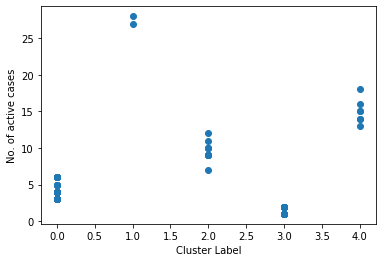

In [85]:
plt.scatter(T_analysis['Cluster Labels'],T_analysis['Total'])
plt.xlabel('Cluster Label')
plt.ylabel('No. of active cases')
plt.show()

In [99]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)


def color_ret(num):
    if num == 1:
            #print(num)
            return('red')            
    elif(num == 4 or num == 2):
            #print(num)
            return('orange')
    else:
            #print(num)
            return('green')

for lat, lng, tot in zip(T_analysis['LATITUDE'], T_analysis['LONGITUDE'], T_analysis['Cluster Labels']):
 #   label = '{}'.format(tot)
 #   label = folium.Popup(label, parse_html=True)
    folium.Marker(
        location=[lat, lng],
        popup='{}'.format(tot),
        icon=folium.Icon(color=color_ret(tot),icon='cloud')).add_to(map_toronto) 

map_toronto